![title](https://i.ibb.co/f2W87Fg/logo2020.png)

---


<table  class="tfo-notebook-buttons" align="left"><tr><td>
    
<a href="https://colab.research.google.com/github/adf-telkomuniv/CV2020_Exercises/blob/main/CV2020 - 10 - Transfer Learning.ipynb" source="blank" ><img src="https://colab.research.google.com/assets/colab-badge.svg"></a>
</td><td>
<a href="https://github.com/adf-telkomuniv/CV2020_Exercises/blob/main/CV2020 - 10 - Transfer Learning.ipynb" source="blank" ><img src="https://i.ibb.co/6NxqGSF/pinpng-com-github-logo-png-small.png"></a>
    
</td></tr></table>



# Task 10 - Transfer Learning


In this assignment you will practice in using the available pretrained model in Keras and use it as a Transfer Learning to fine tune your model

The goals of this assignment are as follows:

    * train and fine tune both full vgg and mini vgg on CIFAR-10
      * train from scratch
      * fine tune all layers
      * train classifier head
      * fine tune selected layers


Write down your Name and Student ID

In [1]:
## --- start your code here ----

NIM = 1301170073
Nama = "Pratama Yoga Santosa"

## --- end your code here ----

---
---
#[Part 0] Import Libraries and Load Data

---
## 1 - Import Libraries
Import required libraries

In [2]:
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import backend as K
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications.vgg16 import VGG16

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model

%matplotlib inline
np.set_printoptions(precision=7)
%load_ext autoreload
%autoreload 2

---
## 2 - Load CIFAR-10

In [3]:
(X_train_ori, y_train), (X_test_ori, y_test) = tf.keras.datasets.cifar10.load_data()

class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


---
## 3 - Split Validation Data

In [4]:
X_val_ori   = X_train_ori[-10000:,:]
y_val       = y_train[-10000:]

X_train_ori = X_train_ori[:-10000, :]
y_train     = y_train[:-10000]

---
## 4 - Normalize and Reshape Data

In [5]:
X_train    = X_train_ori.astype('float32')
X_val      = X_val_ori.astype('float32')
X_test     = X_test_ori.astype('float32')

mean_image = X_train.mean(axis=(0, 1, 2), keepdims=True)
std_image  = X_train.std(axis=(0, 1, 2), keepdims=True)

X_train    = (X_train - mean_image) /std_image
X_val      = (X_val - mean_image) /std_image
X_test     = (X_test - mean_image) /std_image

X_train    = X_train.astype('float32')
X_val      = X_val.astype('float32')
X_test     = X_test.astype('float32')

print('X_train.shape =',X_train.shape)
print('X_val.shape   =',X_val.shape)
print('X_test.shape  =',X_test.shape)

y_train = y_train.ravel()
y_val   = y_val.ravel()
y_test  = y_test.ravel()

print('\ny_train.shape =',y_train.shape)
print('y_val.shape   =',y_val.shape)
print('y_test.shape  =',y_test.shape)

X_train.shape = (40000, 32, 32, 3)
X_val.shape   = (10000, 32, 32, 3)
X_test.shape  = (10000, 32, 32, 3)

y_train.shape = (40000,)
y_val.shape   = (10000,)
y_test.shape  = (10000,)


one hot the label

In [6]:
y_train_hot = to_categorical(y_train, 10)
y_val_hot   = to_categorical(y_val, 10)
y_test_hot  = to_categorical(y_test, 10)

print('y_train_hot.shape =',y_train_hot.shape)
print('y_val_hot.shape   =',y_val_hot.shape)
print('y_test_hot.shape  =',y_test_hot.shape)

y_train_hot.shape = (40000, 10)
y_val_hot.shape   = (10000, 10)
y_test_hot.shape  = (10000, 10)


---
## 5 - Define Hyperparameter

In [7]:
batch_size = 128
epochs = 10
history = {}
scores = {}

---
---
# [Part 1] Helper Function

---
## 1 - Print Model Parameters

Function to display list of layer and trainable status. <br> It also shows the total parameters

Kind of simplified &nbsp;`model.summary()`

In [8]:
def print_params(model):  
    def count_params(weights):
        """Count the total number of scalars composing the weights.
        # Arguments
            weights: An iterable containing the weights on which to compute params
        # Returns
            The total number of scalars composing the weights
        """
        weight_ids = set()
        total = 0
        for w in weights:
            if id(w) not in weight_ids:
                weight_ids.add(id(w))
                total += int(K.count_params(w))
        return total
    
    trainable_count = count_params(model.trainable_weights)
    non_trainable_count = count_params(model.non_trainable_weights)
    
    print('id\ttrainable : layer name')
    print('-------------------------------')
    for i, layer in enumerate(model.layers):
        print(i,'\t',layer.trainable,'\t  :',layer.name)
    print('-------------------------------')

    print('Total params: {:,}'.format(trainable_count + non_trainable_count))
    print('Trainable params: {:,}'.format(trainable_count))
    print('Non-trainable params: {:,}'.format(non_trainable_count))

---
## 2 - Model Builder

Function to build the vgg model to train in cifar-10


In [9]:
def build_model(name, weights='imagenet', cut_at=-1, unfreeze_from=0, opt='adam'):
    
    # load model
    model = VGG16(weights=weights, include_top=False, input_shape=(32,32,3))
    
    # freeze all layer
    for layer in model.layers:
        layer.trainable = False
    
    # select layer output
    if cut_at==-1:
        x = model.output
    else:
        x = model.layers[cut_at].output
        
    # add new classifier head
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dense(512, activation='relu')(x)
    predictions = Dense(10, activation='softmax')(x)

    # instantiate new model
    myModel = Model(inputs=model.input, outputs=predictions, name=name)
        
    # unfreeze selected layer
    for layer in myModel.layers[unfreeze_from:]:
        layer.trainable = True
          
    # compile model
    myModel.compile(
          loss='categorical_crossentropy',
          optimizer=opt, 
          metrics=['accuracy']
    )
          
    # print parameters
    print_params(myModel)
    
    return myModel

---
## 3 - Plot Training History

In [10]:
def plot_history(history):
    plt.rcParams['figure.figsize'] = [12, 4]
    plt.subplots_adjust(wspace=0.2)

    plt.subplot(121)
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'])

    plt.subplot(122)
    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'])
    plt.show()

---
## 4 - Plot All Training Histories

In [11]:
def plot_all(history, labels=None):  
    if labels==None:
        hist = history
    else:
        hist = {k: history[k] for k in labels}
    
    plt.rcParams['figure.figsize'] = [14, 5]
    plt.subplots_adjust(wspace=0.2)
    
    plt.subplot(121)
    for key, h in hist.items():
        plt.plot(h.history['accuracy'], label=key)
    plt.title('Train accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(122)
    for key, h in hist.items():
        plt.plot(h.history['val_accuracy'], label=key)
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.tight_layout()
    plt.show()  
  

---
## 5 - Plot Accuracy Bar

In [12]:
def plot_bar(scores):  
    scores_1={k: scores[k] for k in ('full_scratch', 'full_all', 'full_classifier', 'full_10')}
    scores_2={k: scores[k] for k in ('mini_scratch', 'mini_all', 'mini_classifier', 'mini_10')}
    
    plt.rcParams['figure.figsize'] = [8, 6]
    acc_1, acc_2 = [], []
    labels = ['scratch', 'all', 'classifier', '10']
    x = np.arange(len(labels))
    width = 0.35
    
    for key, s in scores_1.items():
        acc_1.append(s[1])    
        
    for key, s in scores_2.items():
        acc_2.append(s[1])
        
    fig, ax = plt.subplots()
    plt.bar(x - width/2, acc_1, width, label='full')
    plt.bar(x + width/2, acc_2, width, label='mini')
    
    plt.xticks(x,labels)
    plt.title('Test Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Model')
    plt.ylim(0,.9)
    plt.legend()
    plt.tight_layout()
    plt.show()  
  

---
---
# [Part 2] Train Full VGG


As you've tried in previous exercise, now we're going to train Full VGG on CIFAR-10 dataset

Full VGG architecture takes all 13 Conv layers then we add a Global Pooling followed by three FC Layer

we'll compare the performance if we train

    a. the architecture from scratch (random initialization),
    b. fine tune the weight from ImageNet pretrain, 
    c. train the classifier head only, and
    d. fine tune from layer 10 to the classifier head

---
## 1 - Train From Scratch

Let's define our first model

In [13]:
model_1S = build_model('full_scratch', weights=None)

id	trainable : layer name
-------------------------------
0 	 True 	  : input_1
1 	 True 	  : block1_conv1
2 	 True 	  : block1_conv2
3 	 True 	  : block1_pool
4 	 True 	  : block2_conv1
5 	 True 	  : block2_conv2
6 	 True 	  : block2_pool
7 	 True 	  : block3_conv1
8 	 True 	  : block3_conv2
9 	 True 	  : block3_conv3
10 	 True 	  : block3_pool
11 	 True 	  : block4_conv1
12 	 True 	  : block4_conv2
13 	 True 	  : block4_conv3
14 	 True 	  : block4_pool
15 	 True 	  : block5_conv1
16 	 True 	  : block5_conv2
17 	 True 	  : block5_conv3
18 	 True 	  : block5_pool
19 	 True 	  : global_average_pooling2d
20 	 True 	  : dense
21 	 True 	  : dense_1
22 	 True 	  : dense_2
-------------------------------
Total params: 15,245,130
Trainable params: 15,245,130
Non-trainable params: 0


Now train the model for 10 epochs with batch size=100

In [14]:
history[model_1S.name] = model_1S.fit(
    X_train, y_train_hot, 
    validation_data=(X_val, y_val_hot), 
    batch_size=batch_size, 
    epochs=epochs, 
    verbose=2
)

Epoch 1/10
313/313 - 18s - loss: 2.3031 - accuracy: 0.0975 - val_loss: 2.3027 - val_accuracy: 0.0980
Epoch 2/10
313/313 - 17s - loss: 2.3027 - accuracy: 0.0984 - val_loss: 2.3027 - val_accuracy: 0.0980
Epoch 3/10
313/313 - 17s - loss: 2.3027 - accuracy: 0.0971 - val_loss: 2.3027 - val_accuracy: 0.0952
Epoch 4/10
313/313 - 17s - loss: 2.3027 - accuracy: 0.0990 - val_loss: 2.3027 - val_accuracy: 0.0952
Epoch 5/10
313/313 - 17s - loss: 2.3027 - accuracy: 0.0991 - val_loss: 2.3027 - val_accuracy: 0.0980
Epoch 6/10
313/313 - 17s - loss: 2.3027 - accuracy: 0.0969 - val_loss: 2.3028 - val_accuracy: 0.0952
Epoch 7/10
313/313 - 17s - loss: 2.3027 - accuracy: 0.1001 - val_loss: 2.3028 - val_accuracy: 0.0952
Epoch 8/10
313/313 - 17s - loss: 2.3027 - accuracy: 0.0988 - val_loss: 2.3027 - val_accuracy: 0.0952
Epoch 9/10
313/313 - 17s - loss: 2.3027 - accuracy: 0.0991 - val_loss: 2.3027 - val_accuracy: 0.0952
Epoch 10/10
313/313 - 17s - loss: 2.3027 - accuracy: 0.0993 - val_loss: 2.3027 - val_accura

**EXPECTED OUTPUT**:
<pre>
the training loss should plateau around 2.3 
with training accuracy plateau around 10% 

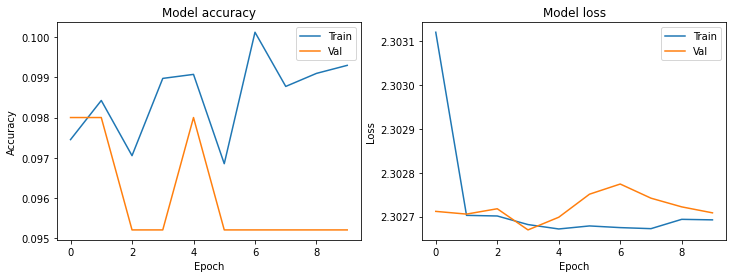


Model Accuracy: 10.00%


In [15]:
plot_history(history[model_1S.name])

scores[model_1S.name] = model_1S.evaluate(X_test, y_test_hot, verbose=0)

print("\nModel Accuracy: %.2f%%" % (scores[model_1S.name][1]*100))

### NOTE
* You should see that the training got stuck at $10\%$ accuracy

* Possible cause is because the model is too deep, too many parameters to train. 

* Another possible cause is as is has been explained before, using 5 blocks of VGG yields to $[1\times1]$ output feature,<br> which is absolutely too little to classify<br> *see &nbsp;`model.summary()`*

---
## 2 - Fine Tune ImageNet Pretrain

Now let's try to fine tune the network using weights taken from ImageNet Pretraining

In [16]:
model_1A = build_model('full_all', weights='imagenet')

id	trainable : layer name
-------------------------------
0 	 True 	  : input_2
1 	 True 	  : block1_conv1
2 	 True 	  : block1_conv2
3 	 True 	  : block1_pool
4 	 True 	  : block2_conv1
5 	 True 	  : block2_conv2
6 	 True 	  : block2_pool
7 	 True 	  : block3_conv1
8 	 True 	  : block3_conv2
9 	 True 	  : block3_conv3
10 	 True 	  : block3_pool
11 	 True 	  : block4_conv1
12 	 True 	  : block4_conv2
13 	 True 	  : block4_conv3
14 	 True 	  : block4_pool
15 	 True 	  : block5_conv1
16 	 True 	  : block5_conv2
17 	 True 	  : block5_conv3
18 	 True 	  : block5_pool
19 	 True 	  : global_average_pooling2d_1
20 	 True 	  : dense_3
21 	 True 	  : dense_4
22 	 True 	  : dense_5
-------------------------------
Total params: 15,245,130
Trainable params: 15,245,130
Non-trainable params: 0


In [17]:
history[model_1A.name] = model_1A.fit(
    X_train, y_train_hot, 
    validation_data=(X_val, y_val_hot), 
    batch_size=batch_size, 
    epochs=epochs, 
    verbose=2
)

Epoch 1/10
313/313 - 17s - loss: 2.3093 - accuracy: 0.1000 - val_loss: 2.3027 - val_accuracy: 0.0996
Epoch 2/10
313/313 - 17s - loss: 2.3027 - accuracy: 0.0980 - val_loss: 2.3027 - val_accuracy: 0.0952
Epoch 3/10
313/313 - 17s - loss: 2.3027 - accuracy: 0.0988 - val_loss: 2.3027 - val_accuracy: 0.0952
Epoch 4/10
313/313 - 17s - loss: 2.3027 - accuracy: 0.0993 - val_loss: 2.3027 - val_accuracy: 0.0952
Epoch 5/10
313/313 - 17s - loss: 2.3027 - accuracy: 0.1001 - val_loss: 2.3027 - val_accuracy: 0.0952
Epoch 6/10
313/313 - 17s - loss: 2.3027 - accuracy: 0.1004 - val_loss: 2.3027 - val_accuracy: 0.0952
Epoch 7/10
313/313 - 17s - loss: 2.3027 - accuracy: 0.1012 - val_loss: 2.3027 - val_accuracy: 0.0952
Epoch 8/10
313/313 - 17s - loss: 2.3027 - accuracy: 0.1003 - val_loss: 2.3027 - val_accuracy: 0.0952
Epoch 9/10
313/313 - 17s - loss: 2.3027 - accuracy: 0.0966 - val_loss: 2.3027 - val_accuracy: 0.0952
Epoch 10/10
313/313 - 17s - loss: 2.3027 - accuracy: 0.0998 - val_loss: 2.3028 - val_accura

**EXPECTED OUTPUT**:
<pre>
the training loss should start around 1.9 and end around 0.35 
with training accuracy start around 20% and end around 88%

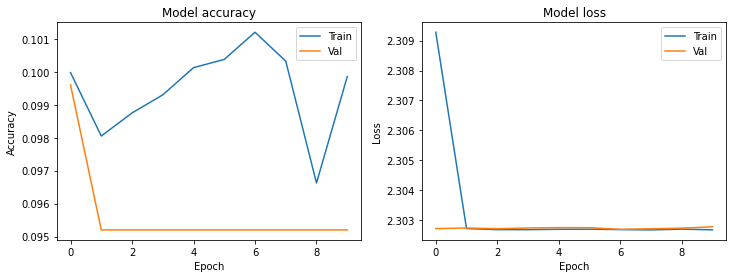


Model Accuracy: 10.00%


In [18]:
plot_history(history[model_1A.name])

scores[model_1A.name] = model_1A.evaluate(X_test, y_test_hot, verbose=0)

print("\nModel Accuracy: %.2f%%" % (scores[model_1A.name][1]*100))

### NOTE
* You should see that the the pretrained weights greatly help the training as the training accuracy jump straight fron $20\%$ to $80\%$

* This happened because the weights already formed the feature extraction from being trained on ImageNet

* And since CIFAR-10 dataset is essentially a subset of ImageNet dataset, the model don't need much to learn the Conv Layers, and just straight to train the classifier head

* As we set all layers trainable, during training, the weights in all Conv layers are also updated to fit the current dataset

---
## 3 - Train Classifier Head

Based on previous explanation, we conclude that the Conv Layers are already trained, so we can just train the classifier head

For that, this time we freeze all layers except the three last FC Layers

In [19]:
model_1C = build_model('full_classifier', weights='imagenet', unfreeze_from=19)

id	trainable : layer name
-------------------------------
0 	 False 	  : input_3
1 	 False 	  : block1_conv1
2 	 False 	  : block1_conv2
3 	 False 	  : block1_pool
4 	 False 	  : block2_conv1
5 	 False 	  : block2_conv2
6 	 False 	  : block2_pool
7 	 False 	  : block3_conv1
8 	 False 	  : block3_conv2
9 	 False 	  : block3_conv3
10 	 False 	  : block3_pool
11 	 False 	  : block4_conv1
12 	 False 	  : block4_conv2
13 	 False 	  : block4_conv3
14 	 False 	  : block4_pool
15 	 False 	  : block5_conv1
16 	 False 	  : block5_conv2
17 	 False 	  : block5_conv3
18 	 False 	  : block5_pool
19 	 True 	  : global_average_pooling2d_2
20 	 True 	  : dense_6
21 	 True 	  : dense_7
22 	 True 	  : dense_8
-------------------------------
Total params: 15,245,130
Trainable params: 530,442
Non-trainable params: 14,714,688


In [20]:
history[model_1C.name] = model_1C.fit(
    X_train, y_train_hot, 
    validation_data=(X_val, y_val_hot), 
    batch_size=batch_size, 
    epochs=epochs, 
    verbose=2
)

Epoch 1/10
313/313 - 6s - loss: 1.1707 - accuracy: 0.5893 - val_loss: 1.0562 - val_accuracy: 0.6308
Epoch 2/10
313/313 - 6s - loss: 0.9459 - accuracy: 0.6672 - val_loss: 1.0015 - val_accuracy: 0.6502
Epoch 3/10
313/313 - 6s - loss: 0.8355 - accuracy: 0.7058 - val_loss: 0.9920 - val_accuracy: 0.6573
Epoch 4/10
313/313 - 6s - loss: 0.7381 - accuracy: 0.7383 - val_loss: 0.9825 - val_accuracy: 0.6609
Epoch 5/10
313/313 - 6s - loss: 0.6398 - accuracy: 0.7747 - val_loss: 1.0088 - val_accuracy: 0.6651
Epoch 6/10
313/313 - 6s - loss: 0.5476 - accuracy: 0.8047 - val_loss: 1.1052 - val_accuracy: 0.6512
Epoch 7/10
313/313 - 6s - loss: 0.4528 - accuracy: 0.8411 - val_loss: 1.1794 - val_accuracy: 0.6526
Epoch 8/10
313/313 - 6s - loss: 0.3631 - accuracy: 0.8749 - val_loss: 1.2576 - val_accuracy: 0.6539
Epoch 9/10
313/313 - 6s - loss: 0.2916 - accuracy: 0.8992 - val_loss: 1.3701 - val_accuracy: 0.6518
Epoch 10/10
313/313 - 6s - loss: 0.2373 - accuracy: 0.9179 - val_loss: 1.4661 - val_accuracy: 0.6492

**EXPECTED OUTPUT**:
<pre>
the training loss should start around 1.2 and end around 0.24 
with training accuracy start around 60% and end around 91%

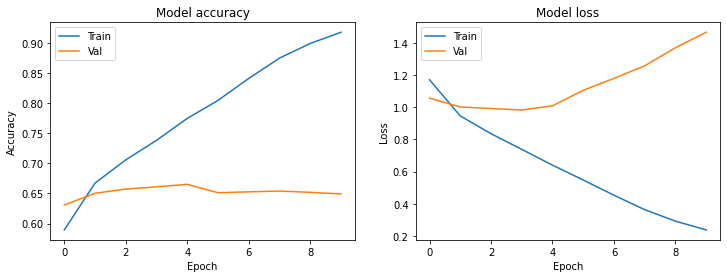


Model Accuracy: 64.32%


In [21]:
plot_history(history[model_1C.name])

scores[model_1C.name] = model_1C.evaluate(X_test, y_test_hot, verbose=0)

print("\nModel Accuracy: %.2f%%" % (scores[model_1C.name][1]*100))

### NOTE
* ***Oh No!*** *The model overfits!*

* This may happened because, again, the model is too deep and the output are just $[1\times1]$

* The feature created from the latter conv layers are too detailed for CIFAR-1 dataset, thus the classifier head overfit to the training set

---
## 4 - Train From Layer 10

So now, let's try to fine tune more layers so that the model can fit better to CIFAR-10 dataset

In here we set to train layers from $4^{th}$ block up to the classifier head

In [22]:
model_1N = build_model('full_10', weights='imagenet', unfreeze_from=10)

id	trainable : layer name
-------------------------------
0 	 False 	  : input_4
1 	 False 	  : block1_conv1
2 	 False 	  : block1_conv2
3 	 False 	  : block1_pool
4 	 False 	  : block2_conv1
5 	 False 	  : block2_conv2
6 	 False 	  : block2_pool
7 	 False 	  : block3_conv1
8 	 False 	  : block3_conv2
9 	 False 	  : block3_conv3
10 	 True 	  : block3_pool
11 	 True 	  : block4_conv1
12 	 True 	  : block4_conv2
13 	 True 	  : block4_conv3
14 	 True 	  : block4_pool
15 	 True 	  : block5_conv1
16 	 True 	  : block5_conv2
17 	 True 	  : block5_conv3
18 	 True 	  : block5_pool
19 	 True 	  : global_average_pooling2d_3
20 	 True 	  : dense_9
21 	 True 	  : dense_10
22 	 True 	  : dense_11
-------------------------------
Total params: 15,245,130
Trainable params: 13,509,642
Non-trainable params: 1,735,488


In [23]:
history[model_1N.name] = model_1N.fit(
    X_train, y_train_hot, 
    validation_data=(X_val, y_val_hot), 
    batch_size=batch_size, 
    epochs=epochs, 
    verbose=2
)

Epoch 1/10
313/313 - 12s - loss: 1.8387 - accuracy: 0.2735 - val_loss: 1.1326 - val_accuracy: 0.5777
Epoch 2/10
313/313 - 12s - loss: 0.9646 - accuracy: 0.6619 - val_loss: 0.9432 - val_accuracy: 0.6871
Epoch 3/10
313/313 - 12s - loss: 0.7453 - accuracy: 0.7487 - val_loss: 0.7347 - val_accuracy: 0.7572
Epoch 4/10
313/313 - 12s - loss: 0.6272 - accuracy: 0.7915 - val_loss: 0.6607 - val_accuracy: 0.7811
Epoch 5/10
313/313 - 12s - loss: 0.5421 - accuracy: 0.8208 - val_loss: 0.6657 - val_accuracy: 0.7861
Epoch 6/10
313/313 - 12s - loss: 0.4811 - accuracy: 0.8398 - val_loss: 0.6297 - val_accuracy: 0.7952
Epoch 7/10
313/313 - 12s - loss: 0.4270 - accuracy: 0.8574 - val_loss: 0.6770 - val_accuracy: 0.8006
Epoch 8/10
313/313 - 12s - loss: 0.3776 - accuracy: 0.8758 - val_loss: 0.6497 - val_accuracy: 0.8001
Epoch 9/10
313/313 - 12s - loss: 0.3378 - accuracy: 0.8879 - val_loss: 0.7640 - val_accuracy: 0.7846
Epoch 10/10
313/313 - 12s - loss: 0.2894 - accuracy: 0.9044 - val_loss: 0.7640 - val_accura

**EXPECTED OUTPUT**:
<pre>
the training loss should start around 1.7 and end around 0.3 
with training accuracy start around 30% and end around 89%

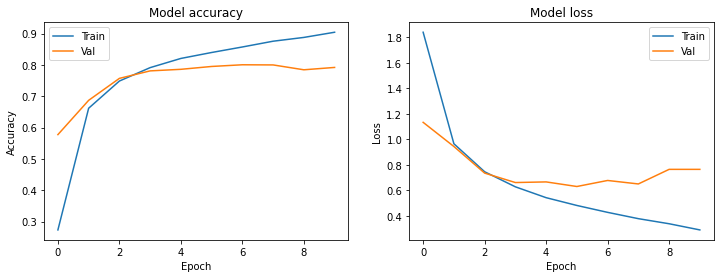


Model Accuracy: 79.08%


In [24]:
plot_history(history[model_1N.name])

scores[model_1N.name] = model_1N.evaluate(X_test, y_test_hot, verbose=0)

print("\nModel Accuracy: %.2f%%" % (scores[model_1N.name][1]*100))

### NOTE
* *Much better*

* By training from much shallower layer, the accuracy has increased

* This happen because the earlier conv layers build a lower feature extraction such as dots, colors, and lines 

* which doesn't need to be changed much to be used in CIFAR-10 dataset

---
## 5 - Comparison

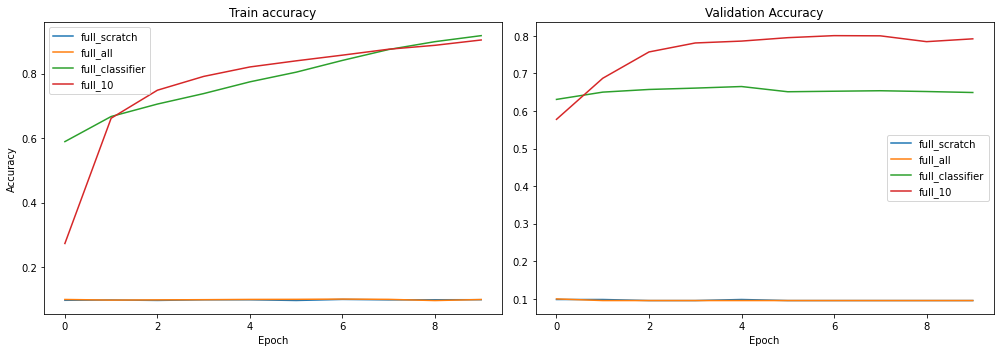

In [25]:
plot_all(history, ['full_scratch', 'full_all', 'full_classifier', 'full_10'])

You should see that the validation accuracy is slightly equal between fine tuned model using all layers and just from layer 10

---
---
# [Part 3] Train Mini VGG

Now let's try all that again, but using Mini VGG

As you've tried to implement in previous exercise, we cut the VGG up to the fourth block, so the output feature activation is not too small, 

Then add three FC layers for classification head

<br>

Again, we'll compare the performance if we train

    a. the architecture from scratch (random initialization),
    b. fine tune the weight from ImageNet pretrain, 
    c. train the classifier head only, and
    d. fine tune from layer 10 to the classifier head

---
## 1 - Train From Scratch

In [26]:
model_2S = build_model('mini_scratch', cut_at=13, weights=None)

id	trainable : layer name
-------------------------------
0 	 True 	  : input_5
1 	 True 	  : block1_conv1
2 	 True 	  : block1_conv2
3 	 True 	  : block1_pool
4 	 True 	  : block2_conv1
5 	 True 	  : block2_conv2
6 	 True 	  : block2_pool
7 	 True 	  : block3_conv1
8 	 True 	  : block3_conv2
9 	 True 	  : block3_conv3
10 	 True 	  : block3_pool
11 	 True 	  : block4_conv1
12 	 True 	  : block4_conv2
13 	 True 	  : block4_conv3
14 	 True 	  : global_average_pooling2d_4
15 	 True 	  : dense_12
16 	 True 	  : dense_13
17 	 True 	  : dense_14
-------------------------------
Total params: 8,165,706
Trainable params: 8,165,706
Non-trainable params: 0


In [27]:
history[model_2S.name] = model_2S.fit(
    X_train, y_train_hot, 
    validation_data=(X_val, y_val_hot), 
    batch_size=batch_size, 
    epochs=epochs, 
    verbose=2
)

Epoch 1/10
313/313 - 13s - loss: 2.0289 - accuracy: 0.2084 - val_loss: 1.7125 - val_accuracy: 0.3022
Epoch 2/10
313/313 - 13s - loss: 1.5327 - accuracy: 0.3999 - val_loss: 1.3556 - val_accuracy: 0.4937
Epoch 3/10
313/313 - 13s - loss: 1.2037 - accuracy: 0.5578 - val_loss: 1.0709 - val_accuracy: 0.6135
Epoch 4/10
313/313 - 13s - loss: 0.9702 - accuracy: 0.6503 - val_loss: 1.0809 - val_accuracy: 0.6397
Epoch 5/10
313/313 - 13s - loss: 0.8143 - accuracy: 0.7098 - val_loss: 0.8589 - val_accuracy: 0.7063
Epoch 6/10
313/313 - 13s - loss: 0.6932 - accuracy: 0.7576 - val_loss: 0.8511 - val_accuracy: 0.7111
Epoch 7/10
313/313 - 13s - loss: 0.5859 - accuracy: 0.7969 - val_loss: 0.7030 - val_accuracy: 0.7640
Epoch 8/10
313/313 - 13s - loss: 0.5064 - accuracy: 0.8247 - val_loss: 0.7679 - val_accuracy: 0.7606
Epoch 9/10
313/313 - 13s - loss: 0.4318 - accuracy: 0.8508 - val_loss: 0.7317 - val_accuracy: 0.7737
Epoch 10/10
313/313 - 13s - loss: 0.3671 - accuracy: 0.8739 - val_loss: 0.9528 - val_accura

**EXPECTED OUTPUT**:
<pre>
the training loss should start around 2 and end around 0.4 
with training accuracy start around 20% and end around 85%

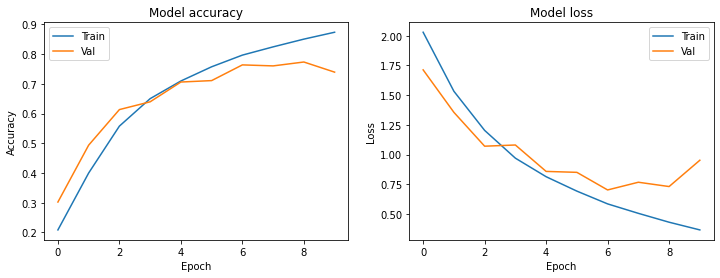


Model Accuracy: 73.30%


In [28]:
plot_history(history[model_2S.name])

scores[model_2S.name] = model_2S.evaluate(X_test, y_test_hot, verbose=0)

print("\nModel Accuracy: %.2f%%" % (scores[model_2S.name][1]*100))

### NOTE
* Training mini VGG from scratch performs much better than Full VGG as the output feature is larger

* With more input, the classifier head can classify better

* <font color='red'>nb: You might get stuck from bad weight initialization, try to re-initialize the model and train it again</font>

---
## 2 - Fine Tune ImageNet Pretrain

Now let's fine tune using ImageNet Pretraining

In [29]:
model_2A = build_model('mini_all', cut_at=13, weights='imagenet')

id	trainable : layer name
-------------------------------
0 	 True 	  : input_6
1 	 True 	  : block1_conv1
2 	 True 	  : block1_conv2
3 	 True 	  : block1_pool
4 	 True 	  : block2_conv1
5 	 True 	  : block2_conv2
6 	 True 	  : block2_pool
7 	 True 	  : block3_conv1
8 	 True 	  : block3_conv2
9 	 True 	  : block3_conv3
10 	 True 	  : block3_pool
11 	 True 	  : block4_conv1
12 	 True 	  : block4_conv2
13 	 True 	  : block4_conv3
14 	 True 	  : global_average_pooling2d_5
15 	 True 	  : dense_15
16 	 True 	  : dense_16
17 	 True 	  : dense_17
-------------------------------
Total params: 8,165,706
Trainable params: 8,165,706
Non-trainable params: 0


In [30]:
history[model_2A.name] = model_2A.fit(
    X_train, y_train_hot, 
    validation_data=(X_val, y_val_hot), 
    batch_size=batch_size, 
    epochs=epochs, 
    verbose=2
)

Epoch 1/10
313/313 - 13s - loss: 1.8655 - accuracy: 0.2652 - val_loss: 1.4101 - val_accuracy: 0.4641
Epoch 2/10
313/313 - 13s - loss: 1.1299 - accuracy: 0.5897 - val_loss: 0.9188 - val_accuracy: 0.6779
Epoch 3/10
313/313 - 13s - loss: 0.8270 - accuracy: 0.7099 - val_loss: 0.7428 - val_accuracy: 0.7391
Epoch 4/10
313/313 - 13s - loss: 0.6588 - accuracy: 0.7739 - val_loss: 0.7110 - val_accuracy: 0.7554
Epoch 5/10
313/313 - 13s - loss: 0.5460 - accuracy: 0.8134 - val_loss: 0.6225 - val_accuracy: 0.7910
Epoch 6/10
313/313 - 13s - loss: 0.4542 - accuracy: 0.8452 - val_loss: 0.5958 - val_accuracy: 0.8028
Epoch 7/10
313/313 - 13s - loss: 0.3773 - accuracy: 0.8702 - val_loss: 0.7197 - val_accuracy: 0.7838
Epoch 8/10
313/313 - 13s - loss: 0.3291 - accuracy: 0.8900 - val_loss: 0.6491 - val_accuracy: 0.8045
Epoch 9/10
313/313 - 13s - loss: 0.2862 - accuracy: 0.9044 - val_loss: 0.6703 - val_accuracy: 0.8015
Epoch 10/10
313/313 - 13s - loss: 0.2297 - accuracy: 0.9224 - val_loss: 0.7343 - val_accura

**EXPECTED OUTPUT**:
<pre>
the training loss should start around 1.9 and end around 0.25
with accuracy start around 25% and end around 91%

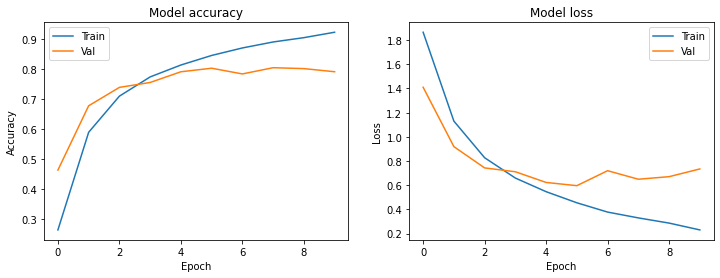


Model Accuracy: 78.74%


In [31]:
plot_history(history[model_2A.name])

scores[model_2A.name] = model_2A.evaluate(X_test, y_test_hot, verbose=0)

print("\nModel Accuracy: %.2f%%" % (scores[model_2A.name][1]*100))

### NOTE
* Training pretrained mini VGG does not decrease the performence

* This validates that the network does not have to be that deep for this small dataset

---
## 3 - Train Classifier Head

So let's try to train the classifier head only

In [32]:
# fine tune classifier head
model_2C = build_model('mini_classifier', cut_at=13, weights='imagenet', unfreeze_from=14)


id	trainable : layer name
-------------------------------
0 	 False 	  : input_7
1 	 False 	  : block1_conv1
2 	 False 	  : block1_conv2
3 	 False 	  : block1_pool
4 	 False 	  : block2_conv1
5 	 False 	  : block2_conv2
6 	 False 	  : block2_pool
7 	 False 	  : block3_conv1
8 	 False 	  : block3_conv2
9 	 False 	  : block3_conv3
10 	 False 	  : block3_pool
11 	 False 	  : block4_conv1
12 	 False 	  : block4_conv2
13 	 False 	  : block4_conv3
14 	 True 	  : global_average_pooling2d_6
15 	 True 	  : dense_18
16 	 True 	  : dense_19
17 	 True 	  : dense_20
-------------------------------
Total params: 8,165,706
Trainable params: 530,442
Non-trainable params: 7,635,264


In [33]:
history[model_2C.name] = model_2C.fit(
    X_train, y_train_hot, 
    validation_data=(X_val, y_val_hot), 
    batch_size=batch_size, 
    epochs=epochs, 
    verbose=2
)

Epoch 1/10
313/313 - 5s - loss: 0.9928 - accuracy: 0.6591 - val_loss: 0.8282 - val_accuracy: 0.7121
Epoch 2/10
313/313 - 5s - loss: 0.7279 - accuracy: 0.7435 - val_loss: 0.7635 - val_accuracy: 0.7351
Epoch 3/10
313/313 - 5s - loss: 0.6270 - accuracy: 0.7794 - val_loss: 0.7679 - val_accuracy: 0.7378
Epoch 4/10
313/313 - 5s - loss: 0.5483 - accuracy: 0.8038 - val_loss: 0.7912 - val_accuracy: 0.7263
Epoch 5/10
313/313 - 5s - loss: 0.4744 - accuracy: 0.8319 - val_loss: 0.7395 - val_accuracy: 0.7521
Epoch 6/10
313/313 - 5s - loss: 0.4119 - accuracy: 0.8525 - val_loss: 0.7520 - val_accuracy: 0.7598
Epoch 7/10
313/313 - 5s - loss: 0.3483 - accuracy: 0.8752 - val_loss: 0.8059 - val_accuracy: 0.7561
Epoch 8/10
313/313 - 5s - loss: 0.2857 - accuracy: 0.8972 - val_loss: 0.8996 - val_accuracy: 0.7475
Epoch 9/10
313/313 - 5s - loss: 0.2365 - accuracy: 0.9150 - val_loss: 0.9050 - val_accuracy: 0.7550
Epoch 10/10
313/313 - 5s - loss: 0.1922 - accuracy: 0.9306 - val_loss: 0.9413 - val_accuracy: 0.7515

**EXPECTED OUTPUT**:
<pre>
the training loss should start around 1.0 and end around 0.2 
with accuracy start around 65% and end around 92%

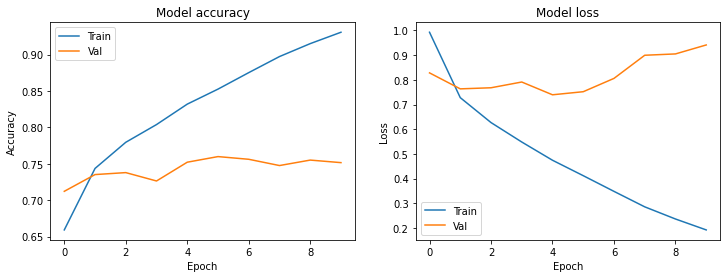


Model Accuracy: 74.71%


In [34]:
plot_history(history[model_2C.name])

scores[model_2C.name] = model_2C.evaluate(X_test, y_test_hot, verbose=0)

print("\nModel Accuracy: %.2f%%" % (scores[model_2C.name][1]*100))

### NOTE
* Seems like training the classifier head only still yields to overfitting

* Though with shallower model, we get slightly better performance

---
## 4 - Train From Layer 10

Now to fine tune the architecture from $4^{th}$ block up to the classifier head 

In [35]:
model_2N = build_model('mini_10', cut_at=13, weights='imagenet', unfreeze_from=10 )

id	trainable : layer name
-------------------------------
0 	 False 	  : input_8
1 	 False 	  : block1_conv1
2 	 False 	  : block1_conv2
3 	 False 	  : block1_pool
4 	 False 	  : block2_conv1
5 	 False 	  : block2_conv2
6 	 False 	  : block2_pool
7 	 False 	  : block3_conv1
8 	 False 	  : block3_conv2
9 	 False 	  : block3_conv3
10 	 True 	  : block3_pool
11 	 True 	  : block4_conv1
12 	 True 	  : block4_conv2
13 	 True 	  : block4_conv3
14 	 True 	  : global_average_pooling2d_7
15 	 True 	  : dense_21
16 	 True 	  : dense_22
17 	 True 	  : dense_23
-------------------------------
Total params: 8,165,706
Trainable params: 6,430,218
Non-trainable params: 1,735,488


In [36]:
history[model_2N.name] = model_2N.fit(
    X_train, y_train_hot, 
    validation_data=(X_val, y_val_hot), 
    batch_size=batch_size, 
    epochs=epochs, 
    verbose=2
)

Epoch 1/10
313/313 - 8s - loss: 1.3130 - accuracy: 0.5436 - val_loss: 0.8742 - val_accuracy: 0.6931
Epoch 2/10
313/313 - 7s - loss: 0.7844 - accuracy: 0.7297 - val_loss: 0.7203 - val_accuracy: 0.7519
Epoch 3/10
313/313 - 7s - loss: 0.6576 - accuracy: 0.7744 - val_loss: 0.6555 - val_accuracy: 0.7757
Epoch 4/10
313/313 - 7s - loss: 0.5845 - accuracy: 0.7988 - val_loss: 0.6338 - val_accuracy: 0.7847
Epoch 5/10
313/313 - 7s - loss: 0.5302 - accuracy: 0.8166 - val_loss: 0.6426 - val_accuracy: 0.7821
Epoch 6/10
313/313 - 7s - loss: 0.4810 - accuracy: 0.8339 - val_loss: 0.6632 - val_accuracy: 0.7861
Epoch 7/10
313/313 - 7s - loss: 0.4347 - accuracy: 0.8504 - val_loss: 0.6085 - val_accuracy: 0.7991
Epoch 8/10
313/313 - 7s - loss: 0.3810 - accuracy: 0.8661 - val_loss: 0.6751 - val_accuracy: 0.7829
Epoch 9/10
313/313 - 7s - loss: 0.3516 - accuracy: 0.8774 - val_loss: 0.6661 - val_accuracy: 0.7948
Epoch 10/10
313/313 - 7s - loss: 0.3013 - accuracy: 0.8939 - val_loss: 0.6814 - val_accuracy: 0.8013

**EXPECTED OUTPUT**:
<pre>
the training loss should start around 1.5 and end around 0.3 
with accuracy start around 45% and end around 89%

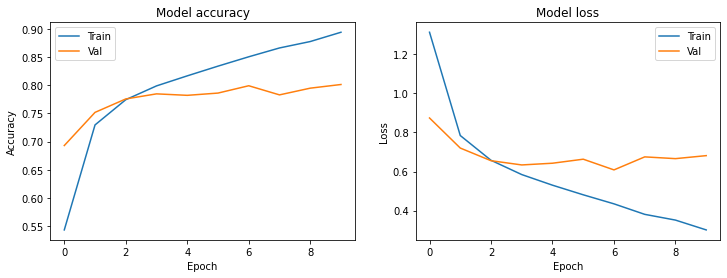


Model Accuracy: 79.72%


In [37]:
plot_history(history[model_2N.name])

scores[model_2N.name] = model_2N.evaluate(X_test, y_test_hot, verbose=0)

print("\nModel Accuracy: %.2f%%" % (scores[model_2N.name][1]*100))

### NOTE
* Again, training from much shallower layer increase the accuracy and prevent overfitting


---
## 5 - Comparison

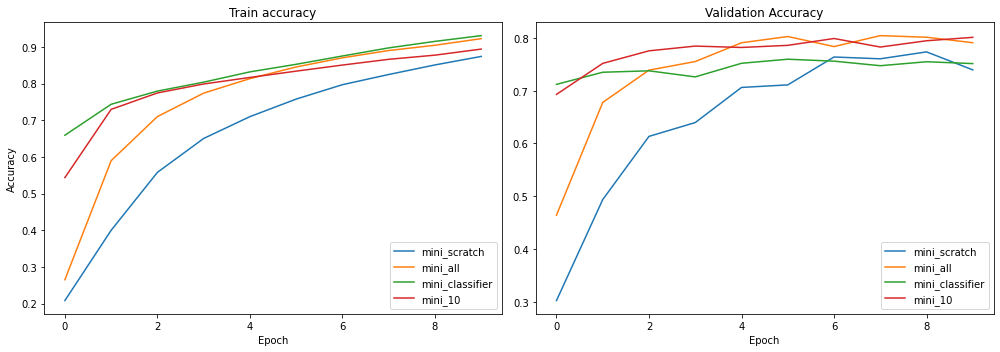

In [38]:
plot_all(history, ['mini_scratch', 'mini_all', 'mini_classifier', 'mini_10'])

You should see that the validation accuracy is slightly equal between fine tuned model using all layers and just from layer 10

---
---

# [Part 4] Overall Scores

Let's show the training, validation, and testing accuracy comprison

---
## 1 - Train-Val Accuracy

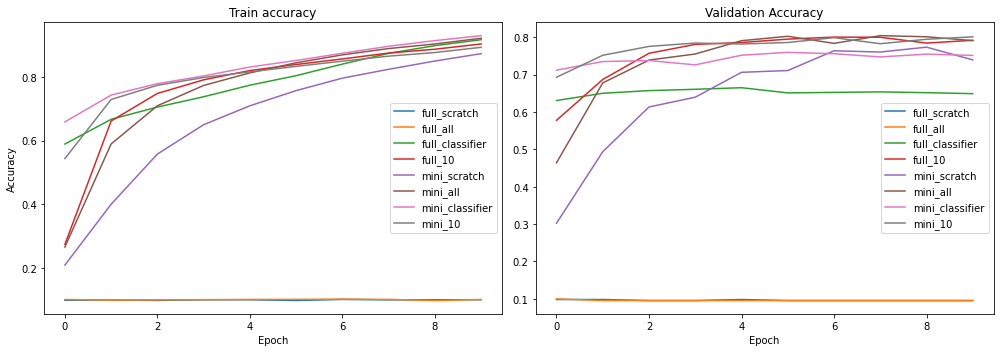

In [39]:
plot_all(history)

---
## 2 - Test Accuracy

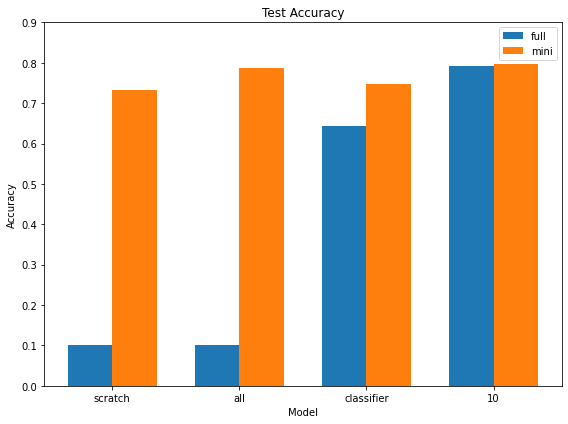

In [40]:
plot_bar(scores)

---
---
# [Part 5] CIFAR-10 Open-ended Challenge

In this section you can experiment with whatever ConvNet architecture you'd like on CIFAR-10.

You should experiment with **architectures**, **hyperparameters**, **loss functions**, **regularization**, or anything else you can think of to train a model 

You should achieve <font color='blue' size='5'><b>at least 90% accuracy</b></font> on the **validation** set <font color='red' size='4'><b>within 10-20 epochs</b></font>. 


---
## Available Models you can try:
- [VGG19](https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg19)
- [InceptionV3](https://www.tensorflow.org/api_docs/python/tf/keras/applications/inception_v3)
- [ResNet](https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet)
- [ResNet v2](https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet_v2)
- [Inception ResNet v2](https://www.tensorflow.org/api_docs/python/tf/keras/applications/inception_resnet_v2)
- [Xception](https://www.tensorflow.org/api_docs/python/tf/keras/applications/xception)
- [DenseNet](https://www.tensorflow.org/api_docs/python/tf/keras/applications/densenet)
- [NasNet](https://www.tensorflow.org/api_docs/python/tf/keras/applications/nasnet)
- [MobileNet](https://www.tensorflow.org/api_docs/python/tf/keras/applications/mobilenet)
- [MobileNet v2](https://www.tensorflow.org/api_docs/python/tf/keras/applications/mobilenet_v2)

---
## Tips for training
For each network architecture that you try, you should tune the learning rate and other hyperparameters. 

When doing this there are a couple important things to keep in mind:

- If the parameters are working well, you should see improvement within a few hundred iterations

- Use small learning rate to fine tune pretrained model

- Once you have found some sets of parameters that seem to work, search more finely around these parameters. You may need to train for more epochs.

- You should use the validation set for hyperparameter search, and save your test set for evaluating your architecture on the best parameters as selected by the validation set.

<center>
<h2><font color='blue'>--- Go Wild, Have Fun, and Happy Training!  --- </font></h2>

---
## 1 - Define Model

---
#### <font color='red'>**EXERCISE:** </font>

    Design your Convolutional Neural Network Architecture

    

In [72]:
model = tf.keras.applications.VGG19(
    weights='imagenet', include_top=False, input_shape=(32,32,3), pooling='avg',
)

x = Dense(512, activation='relu')(model.output)
x = Dense(512, activation='relu')(x)
predictions = Dense(10, activation='softmax')(x)

myModel = Model(inputs=model.input, outputs=predictions, name='my_model')

myModel.summary()

Model: "my_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0  

---
## 2 - Train Model

---
#### <font color='red'>**EXERCISE:** </font>

    Compile the model
    Train the model
    

In [73]:
# Compile model
myModel.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

num_epochs = 30
batch_size = 256

history = myModel.fit(X_train, y_train_hot, 
    validation_data=(X_val, y_val_hot), 
    batch_size=batch_size, 
    epochs=num_epochs, 
    verbose=2)


Epoch 1/30
157/157 - 17s - loss: 2.0571 - accuracy: 0.1880 - val_loss: 1.7965 - val_accuracy: 0.2427
Epoch 2/30
157/157 - 17s - loss: 1.6138 - accuracy: 0.3331 - val_loss: 1.6270 - val_accuracy: 0.3265
Epoch 3/30
157/157 - 17s - loss: 1.3982 - accuracy: 0.4442 - val_loss: 1.3758 - val_accuracy: 0.4596
Epoch 4/30
157/157 - 17s - loss: 1.2253 - accuracy: 0.5263 - val_loss: 1.3943 - val_accuracy: 0.5222
Epoch 5/30
157/157 - 17s - loss: 1.3064 - accuracy: 0.5082 - val_loss: 1.0843 - val_accuracy: 0.5942
Epoch 6/30
157/157 - 17s - loss: 1.0154 - accuracy: 0.6388 - val_loss: 1.0062 - val_accuracy: 0.6600
Epoch 7/30
157/157 - 18s - loss: 0.8854 - accuracy: 0.6933 - val_loss: 0.8816 - val_accuracy: 0.7006
Epoch 8/30
157/157 - 18s - loss: 0.7325 - accuracy: 0.7462 - val_loss: 0.7655 - val_accuracy: 0.7404
Epoch 9/30
157/157 - 18s - loss: 0.6163 - accuracy: 0.7891 - val_loss: 0.7390 - val_accuracy: 0.7504
Epoch 10/30
157/157 - 18s - loss: 0.5189 - accuracy: 0.8252 - val_loss: 0.7435 - val_accura

---
## 3 - Evaluate Model

---
#### <font color='red'>**EXERCISE:** </font>

    evaluate your model on test set
    

In [ ]:
myModelsave('my_model') 

In [74]:
myModel = load_model('my_model')

train_scores = myModel.evaluate(X_train, y_train_hot, verbose=1)
val_scores   = myModel.evaluate(X_val, y_val_hot, verbose=1)
test_scores  = myModel.evaluate(X_test, y_test_hot, verbose=1)

print("\nTraining Accuracy: %.2f%%" % (train_scores[1]*100))
print("Validation Accuracy: %.2f%%" % (val_scores[1]*100))
print("Testing Accuracy:    %.2f%%" % (test_scores[1]*100))

313/313 [==============================] - 3s 10ms/step - loss: 0.9796 - accuracy: 0.8136

Training Accuracy: 98.74%
Validation Accuracy: 81.57%
Testing Accuracy:    81.36%


**EXPECTED OUTPUT**:
<pre>
you should get above 90% of accuracy for train, val, and test set

---
## 4 - Test Model on New Image

For this part, you have to test your model on new image

First of all, search for five images on the Internet, then list the URLs to the code below.

The five images must belong to the 10 CIFAR-10 classes that the model recognizes.

---
#### <font color='red'>**EXERCISE:** </font>

    define five image urls
    one image has been given for an example, you can change it

In [89]:
!wget -q -O 'data_test_0.jpg' 'https://ichef.bbci.co.uk/news/912/cpsprodpb/160B4/production/_103229209_horsea.png'
!wget -q -O 'data_test_1.jpg' 'https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcQ2i9sfizLcoa_0ZNDzWyNbHU10ZEnGRIq7NA&usqp=CAU' # Cat
!wget -q -O 'data_test_2.jpg' 'https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcQCOXayQ1enKT5EYVzc4humtVBLpuM8EMtjQA&usqp=CAU' # Car
!wget -q -O 'data_test_3.jpg' 'https://globalnews.ca/wp-content/uploads/2020/02/airbusier-e1581533974496.jpg?quality=85&strip=all' # Plane
!wget -q -O 'data_test_4.jpg' 'http://blog.nexttruckonline.com/wp-content/uploads/2013/02/OptimusPrime.jpg' # Truck

Run and Recognize the images

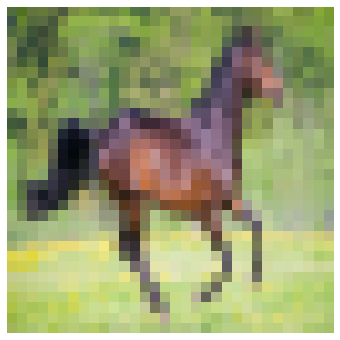

predicted id   : 7
predicted class: horse
--------------------------------




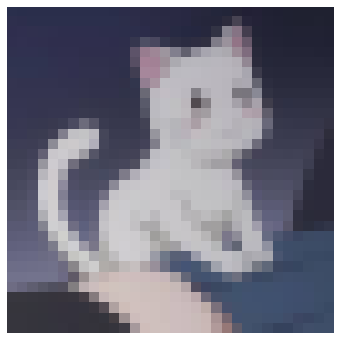

predicted id   : 3
predicted class: cat
--------------------------------




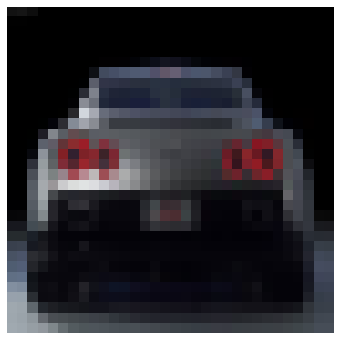

predicted id   : 0
predicted class: plane
--------------------------------




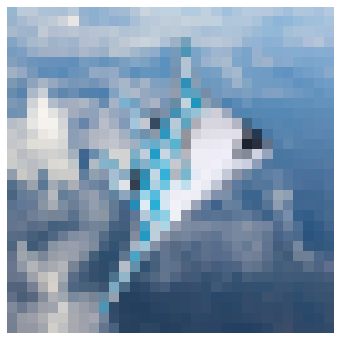

predicted id   : 0
predicted class: plane
--------------------------------




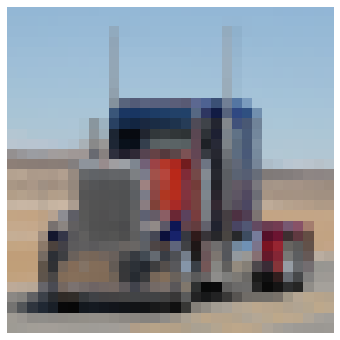

predicted id   : 9
predicted class: truck
--------------------------------




In [90]:
import cv2 as cv
from PIL import Image
class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

mean_pixel = X_train.mean(axis=(0, 1, 2), keepdims=True)
std_pixel = X_train.std(axis=(0, 1, 2), keepdims=True)

for i in range(5):
  new_img = Image.open('data_test_'+str(i)+'.jpg')
  new_img = np.array(new_img)
  new_img2 = cv.resize(new_img, (32,32), interpolation=cv.INTER_AREA)
  plt.imshow(new_img2)
  plt.axis('off')
  plt.show()

  new_img2 = (new_img2 - mean_pixel) / std_pixel
  pred = myModel.predict(new_img2)
  class_id = np.argmax(pred)
  print('predicted id   :',class_id)
  print('predicted class:', class_names[class_id])
  print('--------------------------------\n\n')


---

# Congratulation, You've Completed Exercise 10

<p>Copyright &copy;  <a href=https://www.linkedin.com/in/andityaarifianto/>2020 - ADF</a> </p>

![footer](https://i.ibb.co/yX0jfMS/footer2020.png)